In [2]:
import tensorflow_probability as tfp
import tensorflow as tf

tfd = tfp.distributions 

import setup.input_functions as setfun

# Normal Mutlilevel Model Model

## Background: Case Study
The accompanying example in this case study draws inspiration from the *sleepstudy* dataset (Belenky et al., 2003) that comes along with the R-package *lme4* (Bates et al., 2014). This dataset contains information about the average reaction time (RT) in milliseconds for $N$ individuals who undergo sleep deprivation for nine consecutive nights (with less than three hours of sleep per night). In order to construct a model for this data, we consider a hierarchical model with days serving as a continuous predictor denoted as $x$.

**References**

+ Belenky, G., Wesensten, N. J., Thorne, D. R., Thomas, M. L., Sing, H. C., Redmond, D. P., ... & Balkin, T. J. (2003). Patterns of performance degradation and restoration during sleep restriction and subsequent recovery: A sleep dose‐response study. *Journal of sleep research*, 12(1), 1-12.
+ Bates, D., Mächler, M., Bolker, B., & Walker, S. (2015). Fitting Linear Mixed-Effects Models Using lme4. *Journal of Statistical Software*, 67, 1-48.
  
## Data generating model
\begin{align}
    \begin{split}
    y_{ij} &= \textrm{Normal}(\theta_{ij}, s)\\
    \theta_{ij} &= \beta_{0,j} + \beta_{1,j} x_{ij} \\
    \beta_{0,j} &= \beta_0 + u_{0,j} \\
    \beta_{1,j} &= \beta_1 + u_{1,j} \\
    ( u_{0,j}, u_{1,j} ) &\sim \textrm{MvNormal}\left(\textbf{0}, \Sigma_u\right) \\
    \Sigma_u &= \begin{pmatrix}\tau_0^2 & \rho_{01} \tau_0 \tau_1 \\ \rho_{01} \tau_0 \tau_1 & \tau_1^2\end{pmatrix} \\
    \beta_k &\sim \textrm{Normal}(\mu_k, \sigma_k) \qquad\textrm{ for } k=0,1\\
    \tau_k &\sim \textrm{TruncatedNormal}(0, \omega_k) \qquad\textrm{for } k=0,1\\
    \rho_{01} &\sim \textrm{LKJ}(\alpha_\textrm{LKJ}) \\
    s &\sim \textrm{Gamma}(\alpha, \beta).
    \end{split}
\end{align}
Here $y_{ij}$ represents the average RT for the $j^{th}$ participant at the $i^{th}$ day with $j=1,\ldots, 200$ and $i=0,\ldots,9$. 
The original *sleepstudy* dataset comprises only 18 participants. However, our objective is to assess the validity of our elicitation method by recovering each model (hyper)parameter accurately. To achieve this goal and capture the precise variability indicated by the varying effects, it was necessary to employ a larger sample size.
The RT data is assumed to follow a normal distribution with local mean $\theta_{ij}$ and within-person standard deviation $s$. Here, $\theta_{ij}$ is predicted by a linear combination of the continuous predictor $x$ with overall slope $\beta_1$ and intercept $\beta_0$. 
Given the potential variation in both baseline and change in RT across participants, the model incorporates varying (i.e., *random*) intercepts $u_{0,j}$ and varying slopes $u_{1,j}$. These varying intercepts and slopes follow a multivariate normal distribution, centered at a mean vector of zero and with a covariance matrix $\Sigma_u$. This encodes the variability ($\tau_0, \tau_1$) and the correlation ($\rho_{01}$) between $u_{0,j}$ and $u_{1,j}$. 
For the resulting set of model parameters, the following prior distributions are assumed: A normal distribution for the overall (i.e., ``fixed'') effects $\beta_k$ ($k = 0, 1$) with mean $\mu_k$ and standard deviation $\sigma_k$. A truncated normal distribution centered at zero with a standard deviation of $\omega_k$, is employed for the person-specific variation $\tau_k$, which is constrained to be positive. The correlation parameter $\rho_{01}$ follows a Lewandowski-Kurowicka-Joe distribution with scale parameter $\alpha_\textrm{LKJ}$. In the subsequent context, we set  $\alpha_\textrm{LKJ}$ to 1. Additionally, a Gamma prior distribution with concentration $\alpha$ and rate $\beta$ is used for the within-person (error) standard deviation $s$. The goal is to learn eight hyperparameters $\lambda=(\mu_k,\sigma_k, \omega_k, \alpha, \beta)$.

## Setting up the method
### Model parameters
First, we need to specify the parameters in the generative model using the `param()` function which requires the following input:
+ `name`: the name of the model parameter
    + In our model we have five parameters which we will denote as *b0* (fixed-effect; intercept), *b1* (fixed-effect; slope), *tau0* (random-intercept), *tau1* (random-slope), *sigma* (within-participant variation)
+ `family`: the prior distribution family
    + We assume a Normal prior distribution for the fixed effects, a truncated normal for the random effects and a gamma distribution for the random noise parameter.
    + We created a wrapper around all of these distributions, in order to learn all hyperparameter on the log-scale.
+ `hyperparams_dict`: a dictionary including the name of the hyperparameter values and the initial value for the learning algorithm
    + We use distributions from which an initial value is drawn.
    + When a hyperparameter is learned on the log-scale, we indicate this by writing "log_" before the actual name of the hyperparameter, such as *log_sigma0*.

In [5]:
from user_input.custom_functions import Normal_log_log
from user_input.custom_functions import Gamma_log
from user_input.custom_functions import TruncNormal_log

normal_log = Normal_log_log()
normal_trunc_log = TruncNormal_log(0., 0., 500.)
gamma_log = Gamma_log()

def model_params():  
    return (
        setfun.param(name = "b0",
              family = normal_log, 
              hyperparams_dict = {"log_mu0": tfd.Normal(5.,2.), 
                                  "log_sigma0": tfd.Normal(2.,0.5)}),
        setfun.param(name = "b1",
              family = normal_log, 
              hyperparams_dict = {"log_mu1": tfd.Normal(3.,2.), 
                                  "log_sigma1": tfd.Normal(1.5,0.5)}),
        setfun.param(name = "tau0",
              family = normal_trunc_log, 
              hyperparams_dict = {"log_omega0": tfd.Normal(3.,0.5)}),
        setfun.param(name = "tau1",
              family = normal_trunc_log, 
              hyperparams_dict = {"log_omega1": tfd.Normal(3.,0.5)}),
        setfun.param(name = "sigma",
              family = gamma_log, 
              hyperparams_dict = {"log_concentration": tfd.Normal(5.,0.5), 
                                  "log_rate": tfd.Normal(2.,0.5)})
             )

### Expert data or ground truth for method validation

Next, we define the `expert()` function which represents the data input based on which the method has to learn. 
This can be either 
+ data from an expert (in this case the argument `data` expects a string with the location to the expert data) or
+ an expected ground truth in which case we simulate once from the method using a pre-defined hyperparameter vector $\lambda^*$ and learn then on this simulated data (in this case we need to set the argument `simulate_data = True` and specify the true hyperparameter values in `simulator_specs`.
    
The second approach is helpful when we want to validate our method and check whether the implementation is correct. Because it allows us to check whether we can recover an expected ground truth under *ideal circumstances*.

In [6]:
def expert_input():
    return setfun.expert(data = None,
                  simulate_data = True,
                  simulator_specs = {
                      "b0": tfd.Normal(250.4, 7.27),
                      "b1": tfd.Normal(30.26, 4.82),
                      "tau0": tfd.TruncatedNormal(0., 33., low=0., high=500),
                      "tau1": tfd.TruncatedNormal(0., 23., low=0., high=500),
                      "sigma": tfd.Gamma(200., 8.)
                      })

### Generative model

Now, we can define our generative model from which data should be simulated. We specified the model already formally. 
For implementation purposes a particular *input-output* structure is required:
+ input:
    + (required) `prior_samples`: samples drawn from the prior distributions 
    + (optional) `design_matrix`: design matrix used for the regression model
    + (optional) `selected_days`: days for which expert should be queried
    + (optional) `alpha_lkj`: parameter of the LKJ prior on the correlation which will be fixed to 1.
    + (optional) `N_subj`: number of participants
    + (optional) `N_days`: number of days (selected days for elicitation)
+ output:
    + (required) `likelihood`: model likelihood
    + (required) `ypred`: prior predictions (if likelihood is discrete `ypred=None` as it will be approximated using the Softmax-Gumble method)
    + (required) `epred`: linear predictor
    + (optional) `prior_samples`: we use it here again as output for easier follow-up computations
    + (optional) `meanperday`: distribution of mean reaction time per selected day
    + (optional) `R2day0`: R2 for day 0 (incl. only variation of the random intercept (individual differences in RT without considering the treatment)
    + (optional) `R2day9`: R2 for day 9 (incl. variation of the random intercept and slope (individual differences in RT considering treatment effect)
    + (optional) `mu0sdcomp`:  standard deviation of linear predictor at day 0
    + (optional) `mu9sdcomp`:  standard deviation of linear predictor at day 9
    + (optional) `sigma`: random noise parameter

In [7]:
class GenerativeMultilevelModel(tf.Module):
    def __call__(self, 
                prior_samples,        
                design_matrix, 
                selected_days,
                alpha_lkj,
                N_subj,
                N_days,
                **kwargs        
                ):
        B = prior_samples.shape[0]
        rep = prior_samples.shape[1]
        
        # correlation matrix
        corr_matrix = tfd.LKJ(2, alpha_lkj).sample((B, rep))
        
        # SD matrix
        # shape = (B, 2)
        taus = tf.reduce_mean(
            tf.math.softplus(
                tf.gather(prior_samples, indices=[2,3], axis=-1)
                ), 
            axis=1)
        
        # shape = (B, 2, 2)
        S = tf.linalg.diag(taus)
        
        # covariance matrix: Cov=S*R*S
        # shape = (B, 2, 2)
        corr_mat = tf.linalg.diag(diagonal=(1.,1.), 
                                  padding_value=tf.reduce_mean(corr_matrix))
        # compute cov matrix
        # shape = (B, 2, 2)
        cov_mx_subj = tf.matmul(tf.matmul(S,corr_mat), S)
        
        # generate by-subject random effects: T0s, T1s
        # shape = (B, N_subj, 2)
        subj_rfx = tfd.Sample(
            tfd.MultivariateNormalTriL(
                loc= [0,0], 
                scale_tril=tf.linalg.cholesky(cov_mx_subj)), 
            N_subj).sample()
        
        # broadcast by-subject random effects
        # shape = (B, N_obs, 2) with N_obs = N_subj*N_days
        taus = tf.reshape(
            tf.broadcast_to(
                tf.expand_dims(subj_rfx, axis=2), 
                shape=(B, N_subj, N_days, 2)), 
            shape=(B, N_subj*N_days, 2))
        
        # reshape coefficients
        # shape = (B, rep, N_obs, 2) with N_obs = N_subj*N_days
        betas_reshaped = tf.broadcast_to(
            tf.expand_dims(
                tf.gather(prior_samples, indices=[0,1], axis=-1),
                axis=2), 
            shape=(B, rep, N_subj*N_days, 2))
        
        ## compute betas_s
        # shape = (B, rep, N_obs, 2) with N_obs = N_subj*N_days
        betas = tf.add(betas_reshaped, tf.expand_dims(taus, axis=1)) 
        
        # compute linear predictor term
        # shape = (B, rep, N_obs) with N_obs = N_subj*N_days
        epred = tf.add(betas[:,:,:,0]*design_matrix[:,0], 
                       betas[:,:,:,1]*design_matrix[:,1])
        
        # define likelihood
        likelihood = tfd.Normal(loc = epred,
                                scale = tf.expand_dims(prior_samples[:,:,-1], -1)
                                )
        
        # sample prior predictive data
        ypred = likelihood.sample()
        
        # custom target quantities 
        ## epred averaged over individuals
        epred_days = tf.stack([epred[:,:,i::N_days] for i in range(N_days)], 
                              axis = -1)
        mean_per_day = tf.reduce_mean(epred_days, axis=2)
        
        # R2 for initial day
        R2_day0 = tf.divide(tf.math.reduce_variance(epred[:,:,selected_days[0]::N_days], -1),
                            tf.math.reduce_variance(ypred[:,:,selected_days[0]::N_days], -1))
        
        # R2 for last day
        R2_day9 = tf.divide(tf.math.reduce_variance(epred[:,:,selected_days[-1]::N_days], -1),
                            tf.math.reduce_variance(ypred[:,:,selected_days[-1]::N_days], -1))
        
        # compute standard deviation of linear predictor 
        mu0_sd_comp = tf.math.reduce_std(epred[:,:,selected_days[0]::N_days], 
                                         axis=-1)
        mu9_sd_comp = tf.math.reduce_std(epred[:,:,selected_days[-1]::N_days], 
                                         axis=-1)
        
        return dict(likelihood = likelihood,     
                    ypred = ypred,   
                    epred = epred,
                    prior_samples = prior_samples,
                    meanperday = mean_per_day,
                    R2day0 = R2_day0,
                    R2day9 = R2_day9,
                    mu0sdcomp = mu0_sd_comp,
                    mu9sdcomp = mu9_sd_comp,
                    sigma = prior_samples[:,:,-1]
                    )

After having specified the generative model, we load all information into the `model()` function which requires the following specifications:
+ `generative_model`: the class of the generative model (callable)
+ `additional_model_args`: specifications of model arguments used as input that are not prior samples
    + in this example we have the additional arguments: *design_matrix* and *total_count*. The key name must match with the argument name in the generative model.
+ `discrete_likelihood`: whether likelihood is discrete or not; if *True* the softmax-gumble method will be used in order to approximate `ypred`

In [8]:
from user_input.generative_models import GenerativeMultilevelModel
from user_input.design_matrices import load_design_matrix_sleep

design_matrix = load_design_matrix_sleep("divide_by_std", N_days = 10, 
                                         N_subj = 200, 
                                         selected_days = [0,2,5,6,9])

def generative_model():
    return setfun.model(GenerativeMultilevelModel,
                 additional_model_args = {
                     "design_matrix": design_matrix,
                     "selected_days": [0,2,5,6,9],
                     "alpha_lkj": 1.,
                     "N_subj": 200,
                     "N_days": 5
                     },
                 discrete_likelihood = False
                )

### Target quantities and elicitation techniques
In the next step, we can define the target quantities and the corresponding elicitation technique. Both is specified through the `target()` function which has the following options:
+ `name`: name of the target quantity
    + if you want to use a target quantity which is already specified in the generative model, then you the value for `name` must match with the output argument from the generative model. For this example, `ypred` is taken directly from the generative model.
+ `custom_target_function`: (optional) it is possible to compute custom target quantities from the output of the generative model. Here we compute for example the group means based on the prior predictions. If a custom target function is used the following specifications have to be done:
    + `function`: the respective custom function (callable)
    + `additional_args`: in case the custom function takes as arguments parameters that are not in the output of the generative model, these parameters need to be specified here in form of a dictionary. The argument name is used as key and the respective value. 
+ `elicitation_method`: currently available elicitation methods are *histogram*, *moments*, and *quantiles*
    + some of the elicitation methods require additional specifications:
        + *moments* requires the additional argument `moments_specs` which takes a tuple with the moments that should be elicited e.g. ("mean", "sd")
        + *quantiles* requires the additional argument `quantiles_specs` which takes a tuple with the percentages that should be elicited e.g. (25, 50, 75)
+ `loss_components`: specifies the form of the loss components. Possible values are *by-group*, *by-stats*,*all*. (Detailed description will follow)

In this specific case the implementation is not so currently not so straightforward but will be improved in future.
The target quantities for this model are as follows:
+ *sigma*: the within-participant variation (elicitation in the parameter space)
+ *meanperday*: the distribution of mean reaction time per selected day
+ *R2-day0*: the variance explained (without considering the treatment effect)
+ *R2-day9*: the variance explained (considering the treatment effect

Furthermore, we consider the following definition of $R^2 = \frac{\text{Var}(\mu)}{\text{Var}(y_{pred})}$ with $\mu$ being the linear predictor. 
Then the following holds $\text{SD}(\mu) = \sqrt{R^2 \cdot \text{Var}(y_{pred})}$.
During our simulation studies, we observed that the learning of random effects is improved when we use $\text{SD}(\mu)$ as a loss component instead of $R^2$. That being said, the target quantity queried from an expert would remain $R^2$, but it would be internally transformed, and learning would take place on this transformed value. Therefore, we have two different sets of target quantities.
+ Set 1: Defines the target quantities for the ground truth elicited statistics, whereby $\text{SD}(\mu)$ is used from the simulated data.
+ Set 2: Defines the target quantities for the model simulations whereby we use a custom function which takes as input $R^2$ from the *oracle* (aka expert or here ground truth), uses for $text{Var}(y_{pred})$ the simulated data and returns the respective simulated $\text{SD}(\mu)$.

In [9]:
from user_input.custom_functions import custom_mu0_sd, custom_mu9_sd
from setup.create_dictionaries import create_dict

@create_dict
def target_quantities1(method = "ground_truth"):
    return (
        setfun.target(name = "sigma",
                elicitation_method = "moments",
                moments_specs=("mean","sd"),
                loss_components = "all"
                ),
        setfun.target(name = "mu0sdcomp",
                elicitation_method = "histogram",
                loss_components = "all"
                ),
        setfun.target(name = "mu9sdcomp",
                elicitation_method = "histogram",
                loss_components = "all"
                ),
        setfun.target(name = "meanperday",
                elicitation_method = "quantiles",
                quantiles_specs = (25, 50, 75),
                loss_components = "by-group"
                )
        )

@create_dict
def target_quantities2(method = "learning"):
    return (
        setfun.target(name = "sigma",
                elicitation_method = "moments",
                moments_specs=("mean","sd"),
                loss_components = "all"
                ),
        setfun.target(name = "mu0sdcomp",
                elicitation_method = "histogram",
                loss_components = "all",
                custom_target_function={
                                    "function": custom_mu0_sd,
                                    "additional_args": {"selected_days": [0,2,5,6,9]}
                                    }
                ),
        setfun.target(name = "mu9sdcomp",
                elicitation_method = "histogram",
                loss_components = "all",
                custom_target_function={
                                    "function": custom_mu9_sd,
                                    "additional_args": {"selected_days": [0,2,5,6,9]}
                                    }
                ),
        setfun.target(name = "meanperday",
                elicitation_method = "quantiles",
                quantiles_specs = (25, 50, 75),
                loss_components = "by-group"
                )
        )

### Loss function and optimization settings

The loss function used to compute the discrepancy between the expert and the model-implied elicited statistics is specified via the `loss()` function which has the following arguments:
+ `loss_function`: the discrepancy measure (string: *mmd-energy* or callable)
+ `loss_weighting`: if a weighting scheme for the multiobjective loss function should be used.

For the optimization settings, we consider for the moment only batch stochastic gradient descent for which we need to specify the optimizer using the `optimization()` function, which takes two arguments:
+ `optimizer`: The optimizer that should be used for the current case study (here we use the Adam optimizer)
+ `optimizer_specs`: If further specifications of the optimizer are needed, they are specified here. For the Adam optimizer we need for example an initial learning rate. The additional keyword arguments are specified in form of a dictionary with the key matching the argument name. In this case study we use a cosine decay learning rate schedule with restarts. And we clip the gradient norm at 1.

In [10]:
from functions.loss_functions import MMD_energy

def loss_function():
    return setfun.loss(loss_function = MMD_energy,
                loss_weighting = None
                )

#%% Training settings
def optimization_settings():
    return setfun.optimization(
                    optimizer = tf.keras.optimizers.Adam,
                    optimizer_specs = {
                        "learning_rate": tf.keras.optimizers.schedules.CosineDecayRestarts(
                            0.005, 100),
                        "clipnorm": 1.0
                        }
                    )

### Run the learning algorithm
Finally we can wrap everything up and run the learning algorithm. Therefore we specify the last hyperparameter needed by the learning algorithm with the following `prior_elicitation()` function:
+ `method`: method for learning the prior distributions (currently available: *parametric_prior*)
+ `sim_id`: unique name of model (also used for saving results)
+ `B`: batch size
+ `rep`: number of simulations from the prior distributions
+ `seed`: seed for the current simulation
+ `burnin`: runs before learning starts in order to find good initial values (if drawn randomly)
+ `epochs`: number of learning cycles until learning stops
+ `output_path`: file location for storing results 

In [ ]:
setfun.prior_elicitation(
    method = "parametric_prior",
    sim_id = "mlm_34765522",
    B = 128,
    rep = 200,
    seed = 34765522,
    epochs = 700,
    output_path = "results",
    burnin = 10,
    model_params = model_params,
    expert_input = expert_input,
    generative_model = generative_model,
    target_quantities = (target_quantities1,target_quantities2),
    loss_function = loss_function,
    optimization_settings = optimization_settings,
    log_info = 0,
    view_ep = 1,
    print_info = True
    )

## Evaluating model performance

In [1]:
import validation.plotting as vp 
from vp.plot_learned_prior import learned_prior_multilevel
from vp.plot_diagnostics import diagnostics_multilevel

path = "../sim_results/"
file = "mlm_34765522"
true_values = [250.4, 7.27, 30.26, 4.82, 33., 23., 200., 8.]
selected_obs = [0,2,5,6,9]

### Convergence diagnostics

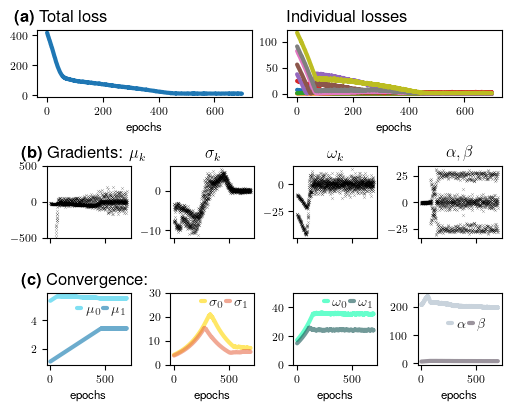

In [12]:
# plot diagnostics
diagnostics_multilevel(path, file, save_fig = False)

### Learned prior distributions

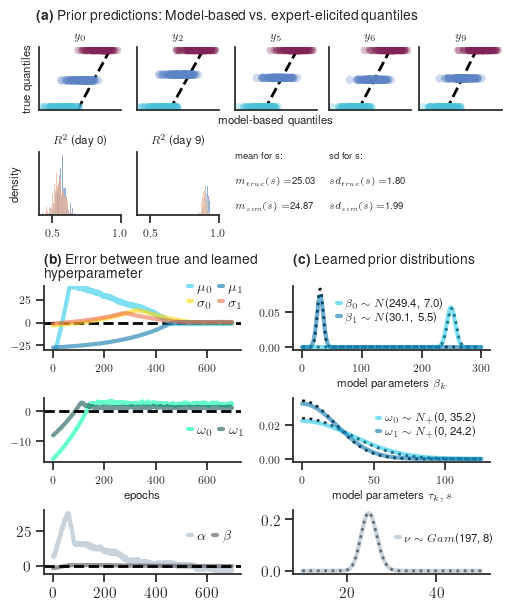

In [13]:
learned_prior_multilevel(path, file, selected_obs, true_values, last_vals = 30, 
                          save_fig = False)

### Summary output

In [2]:
from setup.write_results import model_summary
import pandas as pd

# get global dictionary
global_dict = pd.read_pickle(path+file+"/global_dict.pkl")

# print summary of method specifications
model_summary(path+file, global_dict)

General summary
---------------- 
method=parametric_prior
sim_id=mlm_34765535
seed=34765522
B=128
rep=200
epochs=700
wall time=54:34 (min:sec)
optimizer=<class 'keras.src.optimizers.adam.Adam'>
learning rate={'lr_scheduler': <keras.src.optimizers.schedules.learning_rate_schedule.CosineDecayRestarts object at 0x000001ED78D22340>, 'init_lr': 0.005, 'decay_steps': 100}

Model info
---------------- 
model name=<class 'user_input.generative_models.GenerativeMultilevelModel'>
model parameters=['b0', 'b1', 'tau0', 'tau1', 'sigma']

Parametric Prior
---------------- 
distribution family={'b0': 'Normal_log', 'b1': 'Normal_log', 'tau0': 'TruncatedNormal_log', 'tau1': 'TruncatedNormal_log', 'sigma': 'Gamma_log'}
initialization={'log_mu0': {'loc': 5.0, 'scale': 2.0, 'name': 'Normal'}, 'log_sigma0': {'loc': 2.0, 'scale': 0.5, 'name': 'Normal'}, 'log_mu1': {'loc': 3.0, 'scale': 2.0, 'name': 'Normal'}, 'log_sigma1': {'loc': 1.5, 'scale': 0.5, 'name': 'Normal'}, 'log_omega0': {'loc': 3.0, 'scale': 0.5